In [10]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/diabetes-health-indicators-dataset/diabetes_binary_5050split_health_indicators_BRFSS2015.csv
/kaggle/input/diabetes-health-indicators-dataset/diabetes_binary_health_indicators_BRFSS2015.csv
/kaggle/input/diabetes-health-indicators-dataset/diabetes_012_health_indicators_BRFSS2015.csv


In [11]:
import pandas as pd
import numpy as np
from mlxtend.frequent_patterns import apriori, association_rules
import matplotlib.pyplot as plt

df = pd.read_csv('/kaggle/input/diabetes-health-indicators-dataset/diabetes_012_health_indicators_BRFSS2015.csv')
df.head(-1)

,Diabetes_012,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,...,AnyHealthcare,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income
0,0.0,1.0,1.0,1.0,40.0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,5.0,18.0,15.0,1.0,0.0,9.0,4.0,3.0
1,0.0,0.0,0.0,0.0,25.0,1.0,0.0,0.0,1.0,0.0,...,0.0,1.0,3.0,0.0,0.0,0.0,0.0,7.0,6.0,1.0
2,0.0,1.0,1.0,1.0,28.0,0.0,0.0,0.0,0.0,1.0,...,1.0,1.0,5.0,30.0,30.0,1.0,0.0,9.0,4.0,8.0
3,0.0,1.0,0.0,1.0,27.0,0.0,0.0,0.0,1.0,1.0,...,1.0,0.0,2.0,0.0,0.0,0.0,0.0,11.0,3.0,6.0
4,0.0,1.0,1.0,1.0,24.0,0.0,0.0,0.0,1.0,1.0,...,1.0,0.0,2.0,3.0,0.0,0.0,0.0,11.0,5.0,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
253674,0.0,0.0,0.0,1.0,27.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,3.0,6.0,5.0
253675,0.0,1.0,1.0,1.0,45.0,0.0,0.0,0.0,0.0,1.0,...,1.0,0.0,3.0,0.0,5.0,0.0,1.0,5.0,6.0,7.0
253676,2.0,1.0,1.0,1.0,18.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,4.0,0.0,0.0,1.0,0.0,11.0,2.0,4.0
253677,0.0,0.0,0.0,1.0,28.0,0.0,0.0,0.0,1.0,1.0,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,2.0,5.0,2.0


In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 253680 entries, 0 to 253679
Data columns (total 22 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   Diabetes_012          253680 non-null  float64
 1   HighBP                253680 non-null  float64
 2   HighChol              253680 non-null  float64
 3   CholCheck             253680 non-null  float64
 4   BMI                   253680 non-null  float64
 5   Smoker                253680 non-null  float64
 6   Stroke                253680 non-null  float64
 7   HeartDiseaseorAttack  253680 non-null  float64
 8   PhysActivity          253680 non-null  float64
 9   Fruits                253680 non-null  float64
 10  Veggies               253680 non-null  float64
 11  HvyAlcoholConsump     253680 non-null  float64
 12  AnyHealthcare         253680 non-null  float64
 13  NoDocbcCost           253680 non-null  float64
 14  GenHlth               253680 non-null  float64
 15  

Initially, I dropped 'DiffWalk' and 'Sex' to simplify the analysis, focusing on more direct diabetes-related indicators:

In [13]:
df.drop(['DiffWalk', 'Sex'], axis=1, inplace=True)

# Binning Continuous Variables: Continuous or ordinal variables were binned into meaningful categories:
BMI: Binned using standard medical cutoffs:\
Mental and Physical Health (MentHlth, PhysHlth): Binned into days of poor health:\
Age: Mapped to 13 BRFSS age groups for granularity:\
General Health (GenHlth): Labeled as a categorical scale:\
Education and Income: Converted to categorical strings:\
Diabetes_012: Labeled for clarity:

In [14]:
df['BMI_bin'] = pd.cut(df['BMI'], bins=[0, 18.5, 25, 30, 100], labels=['Underweight', 'Normal', 'Overweight', 'Obese'])

In [15]:
df['MentHlth_bin'] = pd.cut(df['MentHlth'], bins=[-1, 0, 13, 30], labels=['MentHlth_0', 'MentHlth_1-13', 'MentHlth_14-30'])
df['PhysHlth_bin'] = pd.cut(df['PhysHlth'], bins=[-1, 0, 13, 30], labels=['PhysHlth_0', 'PhysHlth_1-13', 'PhysHlth_14-30'])

In [16]:
age_labels = {1: 'Age_18-24', 2: 'Age_25-29', 3: 'Age_30-34', 4: 'Age_35-39', 5: 'Age_40-44', 
              6: 'Age_45-49', 7: 'Age_50-54', 8: 'Age_55-59', 9: 'Age_60-64', 10: 'Age_65-69', 
              11: 'Age_70-74', 12: 'Age_75-79', 13: 'Age_80+'}
df['Age_group'] = df['Age'].map(age_labels)

In [17]:
genhlth_labels = {1: 'GenHlth_Excellent', 2: 'GenHlth_VeryGood', 3: 'GenHlth_Good', 
                  4: 'GenHlth_Fair', 5: 'GenHlth_Poor'}
df['GenHlth_label'] = df['GenHlth'].map(genhlth_labels)

In [18]:
df['Education_label'] = 'Edu_' + df['Education'].astype(str)
df['Income_label'] = 'Income_' + df['Income'].astype(str)

In [19]:
df['Diabetes_label'] = 'Diabetes_' + df['Diabetes_012'].astype(str)

# Selecting Columns: I chose a mix of binary and categorical variables relevant to diabetes:

Binary: ['HighBP', 'HighChol', 'CholCheck', 'Smoker', 'Stroke', 'HeartDiseaseorAttack', 'PhysActivity', 'Fruits', 'Veggies', 'HvyAlcoholConsump', 'AnyHealthcare', 'NoDocbcCost']\
Categorical: ['Diabetes_label', 'BMI_bin', 'MentHlth_bin', 'PhysHlth_bin', 'Age_group', 'GenHlth_label', 'Education_label', 'Income_label']

In [20]:
binary_cols = ['HighBP', 'HighChol', 'CholCheck', 'Smoker', 'Stroke', 'HeartDiseaseorAttack', 
               'PhysActivity', 'Fruits', 'Veggies', 'HvyAlcoholConsump', 'AnyHealthcare', 'NoDocbcCost']
categorical_cols = ['Diabetes_label', 'BMI_bin', 'MentHlth_bin', 'PhysHlth_bin', 'Age_group', 
                    'GenHlth_label', 'Education_label', 'Income_label']

df_bin = df[binary_cols].astype(bool)
df_cat = pd.get_dummies(df[categorical_cols])
df_for_ar = pd.concat([df_bin, df_cat], axis=1)

# Association Rules Mining
I applied association rules mining using the mlxtend library, optimizing for RAM constraints:\
min_support=0.1 ensured itemsets appeared in at least 10% of transactions (25,368 rows), balancing insight and computation.\
**Frequent Itemsets (FI):**

In [40]:
freq_itemsets = apriori(df_for_ar, min_support=0.1, use_colnames=True, low_memory=True)
freq_itemsets = freq_itemsets.sort_values(by='support', ascending=False)
print("\nTop Frequent Itemsets (Sorted by Support):")
print(freq_itemsets.head(10))


Top Frequent Itemsets (Sorted by Support):
      support                                           itemsets
2    0.962670                                        (CholCheck)
7    0.951053                                    (AnyHealthcare)
77   0.920360                         (CholCheck, AnyHealthcare)
8    0.842412                      (Diabetes_label_Diabetes_0.0)
6    0.811420                                          (Veggies)
78   0.806276           (CholCheck, Diabetes_label_Diabetes_0.0)
177  0.800071       (Diabetes_label_Diabetes_0.0, AnyHealthcare)
76   0.781583                               (CholCheck, Veggies)
156  0.774200                           (AnyHealthcare, Veggies)
499  0.770262  (CholCheck, Diabetes_label_Diabetes_0.0, AnyHe...


**Association Rules (AR):**

In [41]:
rules = association_rules(freq_itemsets, metric='confidence', min_threshold=0.5)
rules = rules.sort_values(by='confidence', ascending=False)
print("\nTop Association Rules (Sorted by Confidence):")
print(rules[['antecedents', 'consequents', 'support', 'confidence', 'lift']].head(10))


Top Association Rules (Sorted by Confidence):
                                             antecedents  consequents  \
54429  (Diabetes_label_Diabetes_2.0, HighBP, AnyHealt...  (CholCheck)   
53781  (Veggies, Diabetes_label_Diabetes_2.0, AnyHeal...  (CholCheck)   
29155       (Diabetes_label_Diabetes_2.0, AnyHealthcare)  (CholCheck)   
49800              (Diabetes_label_Diabetes_2.0, HighBP)  (CholCheck)   
49553             (Diabetes_label_Diabetes_2.0, Veggies)  (CholCheck)   
50839  (MentHlth_bin_MentHlth_0, HighChol, AnyHealthc...  (CholCheck)   
39210  (MentHlth_bin_MentHlth_0, PhysActivity, HighCh...  (CholCheck)   
26014                      (Diabetes_label_Diabetes_2.0)  (CholCheck)   
47052  (PhysActivity, HighChol, AnyHealthcare, Fruits...  (CholCheck)   
30536  (AnyHealthcare, MentHlth_bin_MentHlth_0, HighC...  (CholCheck)   

        support  confidence      lift  
54429  0.100410    0.995583  1.034190  
53781  0.100930    0.994948  1.033531  
29155  0.133022    0.994723  

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


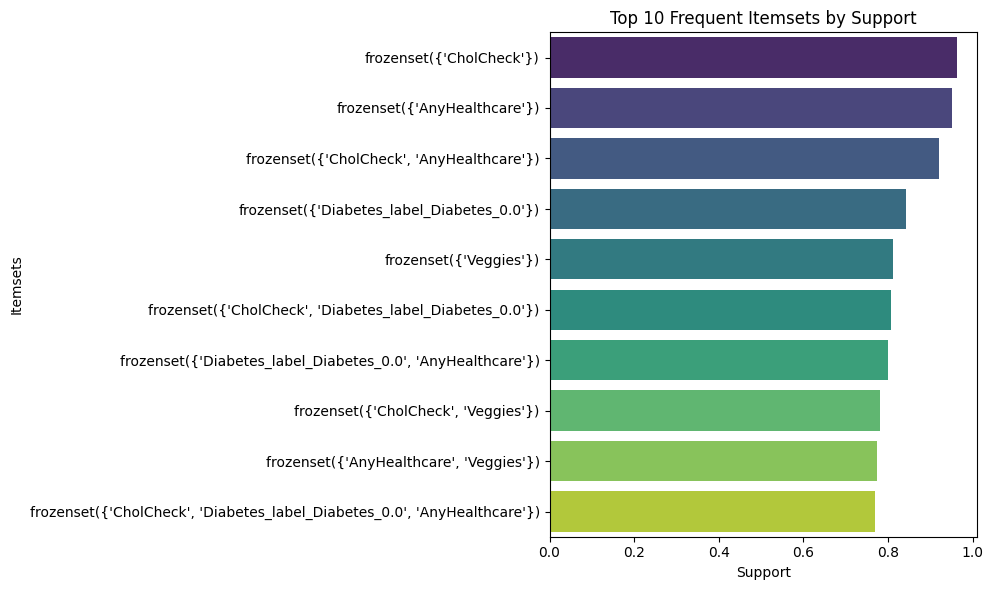

In [42]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
top_freq = freq_itemsets.head(10)
sns.barplot(data=top_freq, x='support', y=top_freq['itemsets'].astype(str), palette='viridis')
plt.title('Top 10 Frequent Itemsets by Support')
plt.xlabel('Support')
plt.ylabel('Itemsets')
plt.tight_layout()
plt.show()

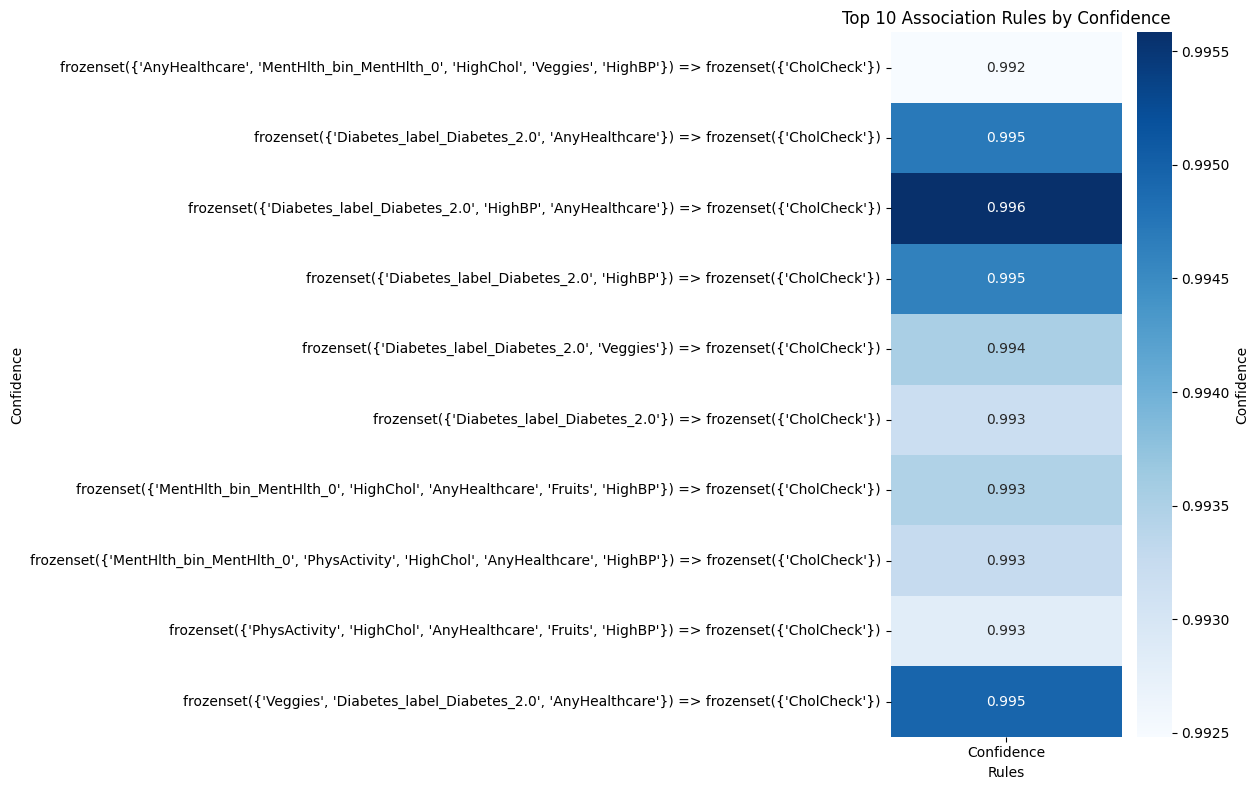

In [44]:
plt.figure(figsize=(12, 8))
top_rules = rules.head(10).reset_index(drop=True)
heatmap_data = pd.DataFrame({
    'Rule': top_rules['antecedents'].astype(str) + ' => ' + top_rules['consequents'].astype(str),
    'Confidence': top_rules['confidence']
})
sns.heatmap(data=heatmap_data.pivot_table(values='Confidence', index='Rule'), annot=True, cmap='Blues', fmt='.3f', cbar_kws={'label': 'Confidence'})
plt.title('Top 10 Association Rules by Confidence')
plt.xlabel('Rules')
plt.ylabel('Confidence')
plt.tight_layout()
plt.show()